## The genomic regions in question

In `03_compartments.ipynb` we extracted the genomic intervals of A compartments on all cell types in all combinations of the following parameters:

* Cell type: fibroblast, spermatocyte, pachytene spermatocyte, round spermatid, sperm
* Chromosome: X
* E1 restriction: full-chromosome, chromosome arms, 10Mb windows
* Resolution: 100 kb, 500 kb

The following parameter was only changed for 100kb resolution:

* Smoothing: No smoothing, 5 bins (500kb) 

Resulting in **45** .csv files. They are saved to `../results/compartments/`.


### Load the data

In [12]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/compartments/'

# Create a dictionary to store the DataFrames
dataframes = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_a_comp_coords_', '_')
        key = os.path.splitext(key)[0]
        dataframes[key] = pd.read_csv(filepath)
        dataframes[key]['length'] = dataframes[key]['end'] - dataframes[key]['start']

# The `dataframes` dictionary now contains the DataFrames
dataframes.keys()

ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')
ech90['length'] = ech90['end'] - ech90['start']


## Time to unleash `genominterv` on the .csv files


### Modules

In [3]:
import genominterv
import pandas as pd

### Define a plotting function

In [4]:
# Kaspers plotting function
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

def plot_intervals(query=None, annot=None, **kwargs):

    tups = []
    if query is not None:
        tups.append(('query', query))
    if annot is not None:
        tups.append(('annot', annot))
    tups.extend(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = label
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)
    fig, axes = plt.subplots(gr.ngroups, 1, figsize=(8, 1.5*gr.ngroups), 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = np.array([axes])
    
    # with plt.style.context(('default')):

    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=0.5, lw=5, colors=f'C{y[0]}')
            delta = len(labels)/10
            axes[i].vlines(df.start.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')
            axes[i].vlines(df.end.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)
    plt.tight_layout()

In [5]:
# My plotting function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from genominterv import interval_intersect

%config InlineBackend.figure_format = 'svg'



def plot_regions(query=None, annot=None, intersect=None):
    chrom = annot['chrom'].unique()[0]
    chromsize = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', header=None, names=['chrom', 'size'])
    chromsize = chromsize[chromsize['chrom'] == chrom]['size'].values[0]
    
    # Define the plot
    height = 1 + (1 if query is not None else 0) + (1 if intersect is not None else 0)
    height = height * 0.75

    f, ax = plt.subplots(figsize=(10, height), sharex=True)
    ax.spines[:].set_visible(False)

    # Plot the annot
    # Iterate over each interval in the DataFrame
    for start, end in zip(annot['start'], annot['end']):
        rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:red', linewidth=0, alpha=0.6)
        ax.add_patch(rect)
        ax.spines['bottom'].set_visible(True)
        lbl = annot['label'].unique()[0] if 'label' in annot.columns else 'A-Comp'
        ax.set_ylabel(lbl, rotation=0, fontsize=10, labelpad=30)

    
    divider = make_axes_locatable(ax)

    if query is not None:
        qax = divider.append_axes("top", size="100%", pad=0.2, sharex=ax)
        qax.xaxis.set_visible(False)
        # Plot the query
        for start, end in zip(query['start'], query['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:blue', linewidth=0, alpha=0.6)
            qax.add_patch(rect)
            qax.spines[:].set_visible(False)
            qax.set_yticks([]) 
            qax.set_title(chrom, loc='left', fontsize=10)
            qax.set_ylabel('ECH90', rotation=0, fontsize=10, labelpad=30)
    
    if intersect is not None:
        iax = divider.append_axes("bottom", size="100%", pad=0.2, sharex=ax)
        # Invisible x-axis for 'annot' (intersect ie below) 
        ax.xaxis.set_visible(False)
        # Plot the intersect
        for start, end in zip(intersect['start'], intersect['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6)
            iax.add_patch(rect)
            iax.spines[:].set_visible(False)
            iax.set_yticks([]) 
            ax.spines['bottom'].set_visible(False)
            iax.spines['bottom'].set_visible(True)
            iax.set_ylabel('Intersect', rotation=0, fontsize=10, labelpad=30)



    ax.set_yticks([])
    ax.set_xlim(0, chromsize)
    ticks = np.linspace(0, chromsize, num=5)
    ax.set_xticks(ticks) 
    ax.set_xticklabels([f'{int(t/1e6)} Mbp' for t in ticks])
    plt.tight_layout()
    return f, ax



### Test with a subsample of the data

153388924


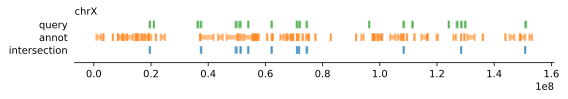

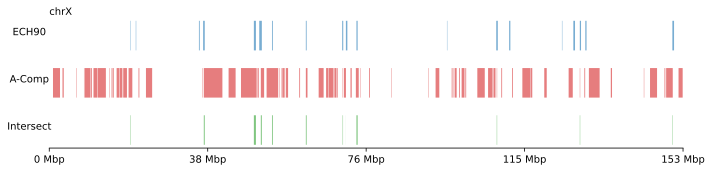

In [5]:

annot = dataframes['round_spermatid_100kb_arms']
query = ech90
intersect = interval_intersect(annot, query)

plot_intervals(query, annot, intersection=intersect)
plot_regions(annot, query, intersect)

Tests for round_spermatid_100kb_arms_smoothed
Proximity: TestResult(statistic=0.20566666666666641, pvalue=0.1049)
Jaccard: 0.03319511172796144

Tests for round_spermatid_100kb_arms
Proximity: TestResult(statistic=0.49242857142857144, pvalue=0.0006)
Jaccard: 0.03916232332293147

Tests for round_spermatid_100kb_10Mb
Proximity: TestResult(statistic=0.3223076923076922, pvalue=0.0193)
Jaccard: 0.04512778341139746

Tests for round_spermatid_100kb_10Mb_smoothed
Proximity: TestResult(statistic=0.4658333333333337, pvalue=0.0029)
Jaccard: 0.04494391747197651



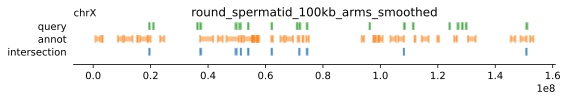

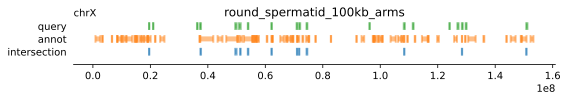

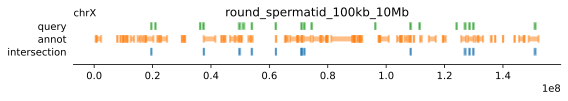

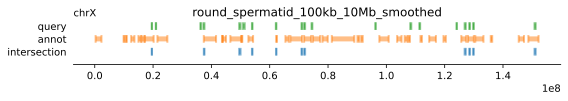

In [6]:
from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect, jaccard

annot = dataframes['fibroblast_500kb_arms']
query = ech90

#plot_intervals(query=query, annot=annot)

for key,annot in dataframes.items():
    # Filter out subset
    if ('round_spermatid_100') in key and not 'full' in key:
        # Plot the intervals
        intersection = interval_intersect(query, annot)
        plot_intervals(query=query, annot=annot, intersection=intersection)
        plt.title(key)

        # Do a proximity test
        print(f"Tests for {key}")
        annot_collapsed = interval_collapse(annot)
        non_ovl_query = interval_diff(query, annot_collapsed)
        print("Proximity:", proximity_test(non_ovl_query, annot_collapsed))
        print("Jaccard:", jaccard(query, annot))
        print()



### Bootstrap to get a p-value

In [7]:
from genominterv import bootstrap

annot = dataframes['round_spermatid_100kb_arms']
chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', index_col='chrom', header=None, names=['chrom','size']).to_dict()['size']
#display(chromsizes)

@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard(query, annot)

jacccard_stat, p_value = jaccard_bootstrap(query, annot)

In [8]:
jacccard_stat, p_value

(0.03916232332293147, 0.283)

### Partition the A-compartments into regions *around* the edges 

In [171]:
df = dataframes['round_spermatid_100kb_arms']

start_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['start']-1*df['resolution'],
    'end': df['start']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'start_edge'
})
end_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['end']-1*df['resolution'],
    'end': df['end']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'end_edge'
})

#df
pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])

,chrom,start,end,resolution,label
0,chrX,800000,1000000,100000,start_edge
0,chrX,2500000,2700000,100000,end_edge
1,chrX,3100000,3300000,100000,start_edge
1,chrX,3400000,3600000,100000,end_edge
2,chrX,6500000,6700000,100000,start_edge
...,...,...,...,...,...
69,chrX,149000000,149200000,100000,end_edge
70,chrX,149200000,149400000,100000,start_edge
70,chrX,150800000,151000000,100000,end_edge
71,chrX,152200000,152400000,100000,start_edge


In [178]:
import os

for key, df in dataframes.items():
    outdir = '../results/edges'
    edge_csv_name = os.path.join(outdir,f'{key+'_edges.csv'}')
    start_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df['start']-1*df['resolution'],
        'end': df['start']+1*df['resolution'],
        'resolution': df['resolution'],
        'label': 'start_edge'
    })
    end_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df['end']-1*df['resolution'],
        'end': df['end']+1*df['resolution'],
        'resolution': df['resolution'],
        'label': 'end_edge'
    })

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end']).to_csv(edge_csv_name, index=False)


### Import edges

In [9]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/edges/'

# Create a dictionary to store the DataFrames
edges = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_edges_', '')
        key = os.path.splitext(key)[0]
        edges[key] = pd.read_csv(filepath)
        edges[key]['length'] = edges[key]['end'] - edges[key]['start']

# The `edges` dictionary now contains the DataFrames
print(edges.keys())
print(edges['fibroblast_100kb_10Mb_edges'].columns)

#ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


dict_keys(['sperm_100kb_arms_smoothed_edges', 'spermatogonia_500kb_full_edges', 'pachytene_spermatocyte_100kb_10Mb_smoothed_edges', 'spermatogonia_100kb_arms_edges', 'fibroblast_500kb_full_edges', 'round_spermatid_500kb_10Mb_edges', 'fibroblast_100kb_arms_edges', 'spermatogonia_100kb_full_smoothed_edges', 'round_spermatid_100kb_full_smoothed_edges', 'round_spermatid_100kb_full_edges', 'fibroblast_100kb_10Mb_edges', 'round_spermatid_500kb_arms_edges', 'fibroblast_100kb_full_smoothed_edges', 'spermatogonia_100kb_10Mb_edges', 'sperm_500kb_arms_edges', 'spermatogonia_100kb_10Mb_smoothed_edges', 'sperm_100kb_full_edges', 'pachytene_spermatocyte_500kb_10Mb_edges', 'pachytene_spermatocyte_100kb_full_smoothed_edges', 'pachytene_spermatocyte_100kb_full_edges', 'pachytene_spermatocyte_500kb_arms_edges', 'fibroblast_100kb_10Mb_smoothed_edges', 'sperm_500kb_10Mb_edges', 'round_spermatid_100kb_10Mb_smoothed_edges', 'spermatogonia_500kb_arms_edges', 'spermatogonia_100kb_full_edges', 'spermatogonia_1

Text(0.5, 0.98, 'End edge')

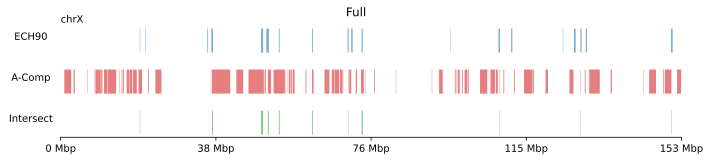

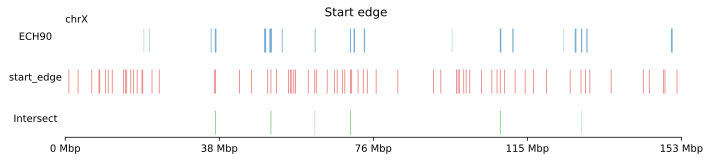

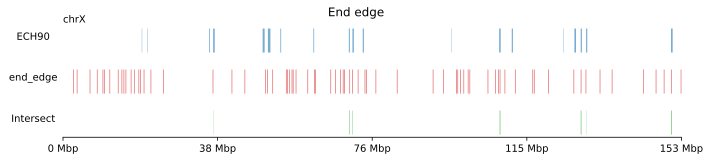

In [17]:
from genominterv import interval_intersect

full_df = dataframes['round_spermatid_100kb_arms']
full_intersect = interval_intersect(full_df, ech90)
full_intersect['length'] = full_intersect['end'] - full_intersect['start']

edge_df = edges['round_spermatid_100kb_arms_edges']
start_edge_df = edge_df[edge_df['label']== 'start_edge']
end_edge_df = edge_df[edge_df['label']== 'end_edge']

start_edge_intersect = interval_intersect(start_edge_df, ech90)
start_edge_intersect['length'] = start_edge_intersect['end'] - start_edge_intersect['start']

end_edge_intersect = interval_intersect(end_edge_df, ech90)
end_edge_intersect['length'] = end_edge_intersect['end'] - end_edge_intersect['start']



# Plot full
plot_regions(ech90, full_df, full_intersect)
plt.suptitle('Full')

# Plot start edge
plot_regions(ech90, start_edge_df, start_edge_intersect)
plt.suptitle('Start edge')

# Plot end edge
plot_regions(ech90, end_edge_df, end_edge_intersect)
plt.suptitle('End edge')

In [21]:
# Determine the proportion of total regions in ECH90 that lies on compartment edges
#display(full_intersect)

print("Proportion of ECH90 on full, start_edge and end_edge (#count)")

# Proportion of ECH90 on full regions
print('\tFull:', full_intersect.size / ech90.size)

# # Proportion of ECH90 on start edges
print('\tStart:', start_edge_intersect.size / ech90.size)

# # Proportion of ECH90 on end edges
print('\tEnd', end_edge_intersect.size / ech90.size)

print("\nProportion of ECH90 on full, start_edge and end_edge (#bpairs)")

# Proportion of ECH90 on full regions
print('\tFull:', full_intersect['length'].sum() / ech90['length'].sum())

# # Proportion of ECH90 on start edges
print('\tStart:', start_edge_intersect['length'].sum() / ech90['length'].sum())

# # Proportion of ECH90 on end edges
print('\tEnd', end_edge_intersect['length'].sum() / ech90['length'].sum())


# # How many of start and end edges are the same (the compartments are small so the edge regions overlap) 

print("\nHow many of start and end edges intersect with each other")
print(f'\t{interval_intersect(start_edge_df, end_edge_df).size} out of {(start_edge_df.size+end_edge_df.size)//2}')

# # When is the intersection between start or end edge and ECH90 the same
print("\nWhen is the intersection between start or end edge and ECH90 the same")
print(f'\t{interval_intersect(start_edge_intersect, end_edge_intersect).size} out of {(start_edge_intersect.size+end_edge_intersect.size)//2}')

# # 

# What is the total length of ech90 regions
print("\nTotal length of ECH90 regions")
print(f'\t{(ech90['end'] - ech90['start']).sum()}')


Proportion of ECH90 on full, start_edge and end_edge (#count)
	Full: 0.7894736842105263
	Start: 0.39473684210526316
	End 0.4605263157894737

Proportion of ECH90 on full, start_edge and end_edge (#bpairs)
	Full: 0.3932398045966063
	Start: 0.18137535322746715
	End 0.17791923507826568

How many of start and end edges intersect with each other
	108 out of 432

When is the intersection between start or end edge and ECH90 the same
	12 out of 32

Total length of ECH90 regions
	5511675


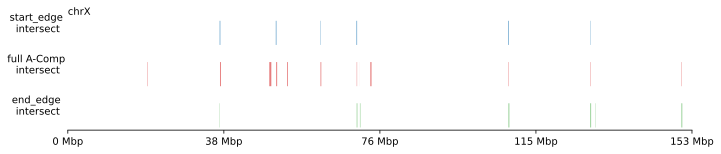

In [22]:
f, ax = plot_regions(start_edge_intersect, full_intersect, end_edge_intersect)

for ax in list(f.axes):
    if ax.get_ylabel() == 'ECH90':
        ax.set_ylabel('start_edge \nintersect', rotation=0, fontsize=10, labelpad=30)
    if ax.get_ylabel() == 'A-Comp':
        ax.set_ylabel('full A-Comp \nintersect', rotation=0, fontsize=10, labelpad=30)
    if ax.get_ylabel() == 'Intersect':
        ax.set_ylabel('end_edge \nintersect', rotation=0, fontsize=10, labelpad=30)
        

### Do testing of the edges

In [32]:
%%capture
# Define what we are testing

print("""
Goal: To test whether ECH90 regions are enriched in compartment edges
Query: ECH90
Annotation: Start and end edges of compartments

Hypothesis: 
      ECH90 regions are enriched in compartment edges
Null hypothesis: 
      ECH90 regions are not enriched in compartment edges

Tests: 
* Proximity test: 
      tests whether the query regions are closer to 
      the annotation regions than expected by chance. 
      NB regions can not overlap, so we need to collapse the annotation regions

* Jaccard index: 
      tests the similarity between the query and annotation regions, 
      where a value of 1 indicates perfect overlap
""")

In [52]:
### Proximity test ###

from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect

# Define the query and annotation
query = ech90
annot_start = start_edge_df
annot_end = end_edge_df

# I don't know if this is correct, but I think it's the non-overlapping regions of the query
annot_concat = interval_diff(annot_start, annot_end)

# Collapse the annotation regions
annot_start_collapsed = interval_collapse(annot_start)
annot_end_collapsed = interval_collapse(annot_end)
annot_concat_collapsed = interval_collapse(annot_concat)

# Calculate the non-overlapping query regions
non_ovl_query_start = interval_diff(query, annot_start_collapsed)
non_ovl_query_end = interval_diff(query, annot_end_collapsed)
non_ovl_query_concat = interval_diff(query, annot_concat_collapsed)

# Perform the proximity test
proximity_start = proximity_test(non_ovl_query_start, annot_start_collapsed, two_sided=True)
proximity_end = proximity_test(non_ovl_query_end, annot_end_collapsed, two_sided=True)
proximity_concat = proximity_test(non_ovl_query_concat, annot_concat_collapsed, two_sided=True)

print("Proximity test results")
print(f"Start edge: statistic: {proximity_start.statistic}, p-value: {proximity_start.pvalue}")
print(f"End edge: statistic: {proximity_end.statistic}, p-value: {proximity_end.pvalue}")
print(f"Concat edge: statistic: {proximity_concat.statistic}, p-value: {proximity_concat.pvalue}")

# Make a nice pd table of this
proximity_results = pd.DataFrame({
    'Edge': ['Start', 'End', 'Concat'],
    'Statistic': [proximity_start.statistic, proximity_end.statistic, proximity_concat.statistic],
    'P-value': [proximity_start.pvalue, proximity_end.pvalue, proximity_concat.pvalue]
})

proximity_results

Proximity test results
Start edge: statistic: 0.15076190476190474, p-value: 0.1154
End edge: statistic: 0.137411764705882, p-value: 0.1629
Concat edge: statistic: 0.21838095238095215, p-value: 0.0404


,Edge,Statistic,P-value
0,Start,0.150762,0.1154
1,End,0.137412,0.1629
2,Concat,0.218381,0.0404


In [54]:
### Jaccard index ###

from genominterv import jaccard, bootstrap

chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', index_col='chrom', header=None, names=['chrom','size']).to_dict()['size']


# Calculate the Jaccard index
jaccard_start = jaccard(query, annot_start)
jaccard_end = jaccard(query, annot_end)
jaccard_concat = jaccard(query, annot_concat)

print("\nJaccard index results")
print(f"Start edge: {jaccard_start}")
print(f"End edge: {jaccard_end}")
print(f"Concat edge: {jaccard_concat}")

# Test with bootstrap decorator
@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard(query, annot)

jaccard_stat_start, p_value_start = jaccard_bootstrap(query, annot_start)
jaccard_stat_end, p_value_end = jaccard_bootstrap(query, annot_end)
jaccard_stat_concat, p_value_concat = jaccard_bootstrap(query, annot_concat)

# Make a nice pd table with the results
results = pd.DataFrame({
    'Jaccard Index': [jaccard_start, jaccard_end, jaccard_concat],
    'Bootstrap Statistic': [jaccard_stat_start, jaccard_stat_end, jaccard_stat_concat],
    'Bootstrap P-value': [p_value_start, p_value_end, p_value_concat]
}, index=['Start', 'End', 'Concat'])

results



Jaccard index results
Start edge: 0.05285968538588186
End edge: 0.05180026540535909
Concat edge: 0.04261284973727925


,Jaccard Index,Bootstrap Statistic,Bootstrap P-value
Start,0.052860,0.052860,0.028
End,0.051800,0.051800,0.032
Concat,0.042613,0.042613,0.107


### Check the length of the intervals

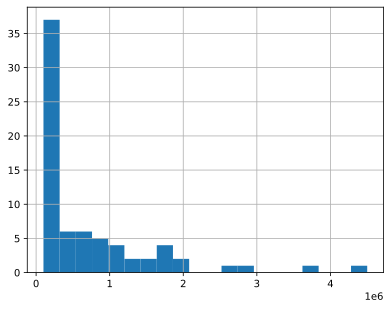

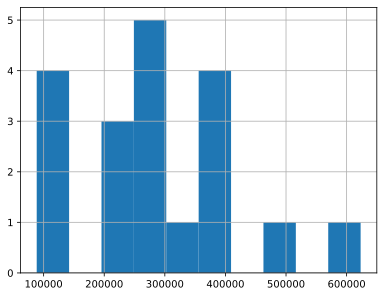

In [85]:
# Plot histogram of the lengths of the A compartments from the full regions

full_df['length'] = full_df['end'] - full_df['start']
full_df['length'].mean()

plt.figure()
full_df['length'].hist(bins=20)
plt.show()

plt.figure()
(ech90['end']-ech90['start']).hist(bins=10)
plt.show()

## Bioframe genomic intervals support


In [ ]:
import bioframe 

## Geneinfo 

How does the edges align with genes?

This first plot is just to figure out how to plot with `gene_plot`.

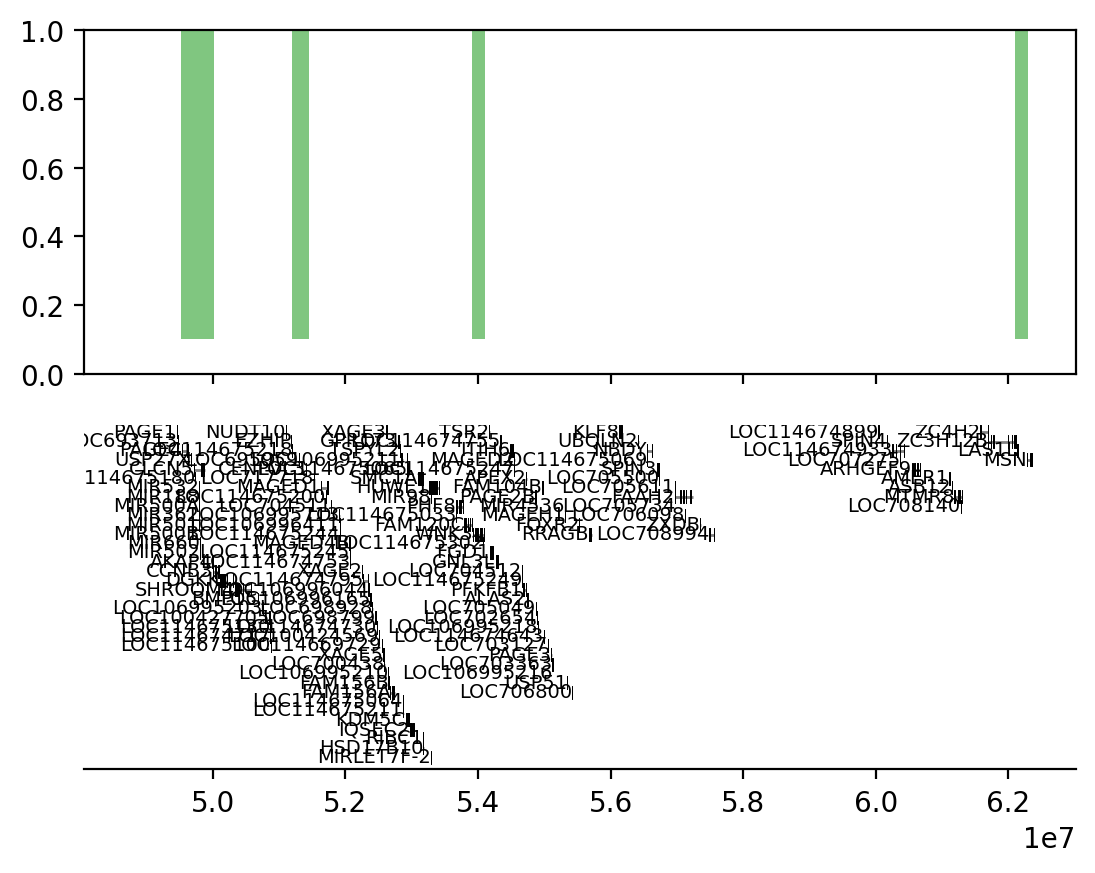

In [71]:
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

start = full_intersect['start'][2]
end = full_intersect['end'][5]

rectangles = [Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][2:6], full_intersect['end'][2:6])]

pc = PatchCollection(rectangles, match_original=True)

ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10')
ax.add_collection(pc)

In [93]:
# Use get_genes_region

import geneinfo as gi

annot_concat = annot_concat[annot_concat.apply(lambda x: x['end'] - x['start'] != 0, axis=1)]
length = annot_concat.apply(lambda x: x['end']-x['start'], axis=1)
length

annot_concat
genes = annot_concat.apply(lambda x: gi.get_genes_region('chrX', x['start'], x['end'], assembly='rheMac10'), axis =1)

genes

0     [(CRLF2, 857257, 884244, -, [(857257, 857951),...
1     [(LOC114675238, 3133375, 3133509, -, [(3133375...
2     [(PUDP, 6518504, 6689158, -, [(6518504, 651941...
3     [(FAM9A, 8341776, 8350296, -, [(8341776, 83420...
4                                                    []
                            ...                        
67    [(LOC114675184, 143842344, 143842446, +, [(143...
68                                                   []
69    [(CETN2, 148839869, 148843240, -, [(148839869,...
70    [(PNMA6F, 149287542, 149291654, -, [(149287542...
71                                                   []
Length: 71, dtype: object

In [ ]:
#pd.DataFrame(genes).to_csv('../results/genes.csv')